**Method:**
- The average emittance between Set 1 and Set 2 is used here.
- The average of the acquisition time is considered here as well **to be confirmed that is correct**

**Note:**
- Set 1: IN acquisition of the WS
- Set 2: OUT acquisition of the WS


In [59]:
import os
import datascout as ds
import awkward as ak
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as md
import statistics

In [60]:
# Plotting parameters
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 10,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [61]:
path2files = './example_WS_data_19Aug2021/'
files_list = sorted(os.listdir(path2files)[:-1])
print(files_list)

['2021.08.19.13.49.24.135000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.13.50.40.935000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.13.55.09.735000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.13.57.04.935000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.14.32.55.335000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.14.48.55.335000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.15.08.45.735000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.15.13.14.535000_SPS.BWS.41677.V-PM1.parquet', '2021.08.19.15.18.21.735000_SPS.BWS.41677.V-PM1.parquet']


## Part A:  Analysis for 1/80 bunches only for the Set 1 (IN acquisitions)

In [62]:
entry = 0
subentries = np.arange(0,80) # how many bunches
subsubentry=0 

In [63]:
# select bunch
bunch = subentries[0]

emit_list_1, days_list_1  = [], []
emit_list_2, days_list_2  = [], []

for filename in files_list:
    data = ds.parquet_to_awkward(path2files+filename) # type: awkward.highlevel.Array
    pd_data = ak.to_pandas(data) # convert awkward arrays to pandas for easier manipilation

    acq_1 = pd_data['cycleStamp'][0][bunch][0]/1e9+ pd_data['acq_time_Set1'][0][bunch][0]/1e6 # sec
    acq_2 = pd_data['cycleStamp'][0][bunch][0]/1e9+ pd_data['acq_time_Set2'][0][bunch][0]/1e6 # sec
    
    
    t_corr = 2*3600
    days_list_1.append(md.epoch2num(acq_1+t_corr))  # Convert UNIX time to days since Matplotlib epoch.
    days_list_2.append(md.epoch2num(acq_2+t_corr))  # Convert UNIX time to days since Matplotlib epoch.
    
    emit_list_1.append(pd_data['emittance_Set1'][0][bunch][0])
    emit_list_2.append(pd_data['emittance_Set2'][0][bunch][0])

In [64]:
## compute average between Set 1 and Set 2
emit_list_mean = [statistics.mean(k) for k in zip(emit_list_1, emit_list_2)]
emit_list_std =  [statistics.stdev(k) for k in zip(emit_list_1, emit_list_2)]

days_list_mean = [statistics.mean(k) for k in zip(days_list_1, days_list_2)]

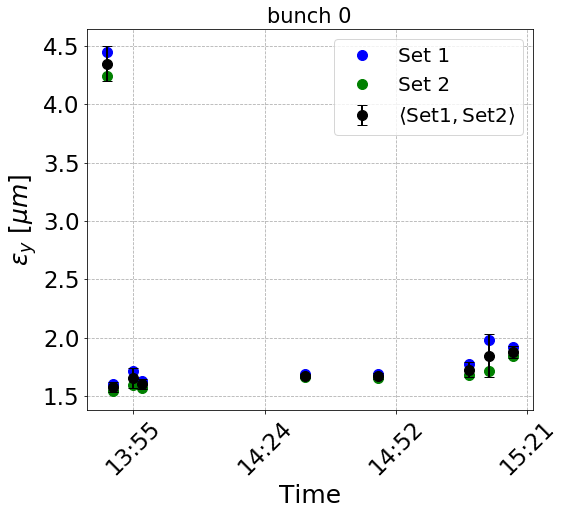

In [65]:
fig, ax = plt.subplots(1)

xfmt = md.DateFormatter('%H:%M')
    
ax.plot(days_list_1, np.array(emit_list_1)*1e6, 'o', c='b', label='Set 1')
ax.plot(days_list_2, np.array(emit_list_2)*1e6, 'o', c='g', label='Set 2')

ax.errorbar(days_list_mean, np.array(emit_list_mean)*1e6, yerr=np.array(emit_list_std)*1e6, marker='o', ls='',c='k', capsize=5, zorder=50, label=r'$\mathrm{\langle Set 1, Set 2 \rangle}$')

    
ax.set_title(f'bunch {bunch}')
ax.set_xlabel('Time')
ax.set_ylabel(r'$\epsilon_y \ [\mu m]$')
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=45)
plt.gca().xaxis.set_major_formatter(xfmt)
plt.grid(ls='--')

In [66]:
# compute the emit grwoth in m/day

# Set 1
[m_1, b_1], cov = np.polyfit(days_list_1[1:], emit_list_1[1:], deg=1, cov=True)
err_1 = np.sqrt(np.diag(cov))[0]
print ("Slope : " + str(m_1))
print ("Intercept : " + str(b_1))

# Set 2
[m_2, b_2], cov = np.polyfit(days_list_2[1:], emit_list_2[1:], deg=1, cov=True)
err_2 = np.sqrt(np.diag(cov))[0]
print ("Slope : " + str(m_2))
print ("Intercept : " + str(b_2))

# Mean Set 1 and Set 2
##### WEIGHTED POLYFIT ######
# documentation: https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
# what does it mean for gaussian uncertainties --> sigma is the error of the value
weights = 1/np.array(emit_list_std[1:])
#weights = 1/np.array(emit_list_std[1:])**2
[m_mean, b_mean], cov = np.polyfit(days_list_mean[1:], emit_list_mean[1:], deg=1, w=weights, cov=True)
err_mean = np.sqrt(np.diag(cov))[0]
print ("Slope : " + str(m_mean))
print ("Intercept : " + str(b_mean))

Slope : 4.238123390396617e-06
Intercept : -3.1278248897648506
Slope : 3.232831027741542e-06
Intercept : -2.3858974951716174
Slope : 3.325857177807125e-06
Intercept : -2.454552783276983


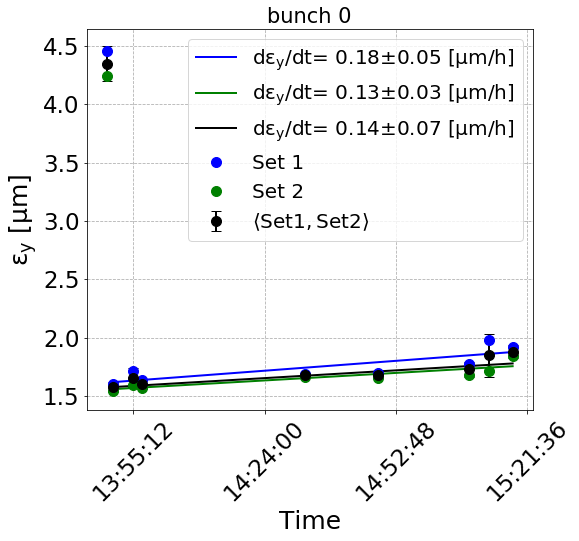

In [71]:
fig, ax = plt.subplots(1)

xfmt = md.DateFormatter('%H:%M:%S')
    
# Set 1
ax.errorbar(days_list_1, np.array(emit_list_1)*1e6, marker='o', ls='',c='b', capsize=5, zorder=50, label='Set 1')
ax.plot(days_list_1[1:], (np.array(days_list_1[1:])*m_1+b_1)*1e6, c='b', label=r'$\mathrm{d\epsilon_y/dt}$'+f'= {m_1*1e6/24:.2f}'+r'$\pm$'+f'{err_1*1e6/24:.2f} '+r'$\mathrm{[\mu m/h]}$')

# Set 2
ax.errorbar(days_list_2, np.array(emit_list_2)*1e6, marker='o', ls='',c='g', capsize=5, zorder=50, label='Set 2')
ax.plot(days_list_2[1:], (np.array(days_list_2[1:])*m_2+b_2)*1e6, c='g', label=r'$\mathrm{d\epsilon_y/dt}$'+f'= {m_2*1e6/24:.2f}'+r'$\pm$'+f'{err_2*1e6/24:.2f} '+r'$\mathrm{[\mu m/h]}$')


    
ax.errorbar(days_list_mean, np.array(emit_list_mean)*1e6, yerr=np.array(emit_list_std)*1e6, marker='o', ls='',c='k', capsize=5, zorder=50, label=r'$\mathrm{\langle Set 1, Set 2 \rangle}$')
ax.plot(days_list_mean[1:], (np.array(days_list_mean[1:])*m_mean+b_mean)*1e6, c='k', label=r'$\mathrm{d\epsilon_y/dt}$'+f'= {m_mean*1e6/24:.2f}'+r'$\pm$'+f'{err_mean*1e6/24:.2f} '+r'$\mathrm{[\mu m/h]}$')

ax.set_title(f'bunch {bunch}')
ax.set_xlabel('Time')
ax.set_ylabel(r'$\mathrm{\epsilon_y \ [\mu m]}$')
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=45)
plt.gca().xaxis.set_major_formatter(xfmt)
plt.grid(ls='--')